# Aquafarm Mapping using Pytorch
Creator: Isabelle Tingzon, Ren Flores

The goal of the notebook is to provide an example of how to use the Aquafarm Image dataset. Here, you will learn how to train a computer vision model to identify if an image contains aquafarms using publicly available Sentinel-2 satellite imagery.

You can make a copy of this tutorial by clicking File→Save a copy in Drive.

# Table of Contents

*   [Overview](#overview)
*   [Target Audience](#target-audience)
*   [Background & Prerequisites](#background-and-prereqs)
*   [References](#references)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology](#methodology)
*   [Results & Discussion](#results-and-discussion)


<a name="overview"></a>
# Overview

In this tutorial, you will learn how to:
- Train a computer vision model for semantic segmentation 
- Create a Pytorch implementation of the U-net architecture
- Save and load trained models


<a name="target-audience"></a>
# Target Audience
This tutorial is aimed at data scientists with prior background in deep learning looking for concrete examples on the application of deep learning models to tackle a problem in climate change.

<a name="background-and-prereqs"></a>
# Background and Prerequisites
This tutorial is intended for data scientists with prior knowledge of machine learning concepts, including neural networks. 

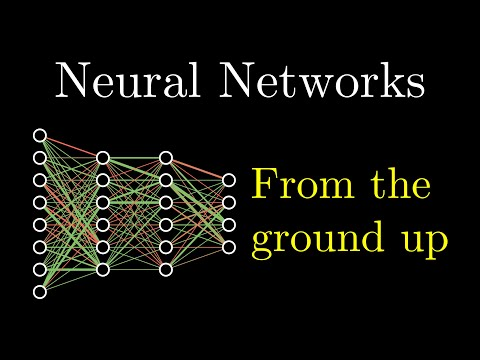

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('aircAruvnKk')

<a name="references"></a>
# References

*  C. Yeh, C. Meng, S. Wang, A. Driscoll, E. Rozi, P. Liu, J. Lee, M. Burke, D. Lobell, and S. Ermon, “SustainBench: Benchmarks for Monitoring the Sustainable Development Goals with Machine Learning,” in Thirty-fifth Conference on Neural Information Processing Systems, Datasets and Benchmarks Track (Round 2), Dec. 2021. [Online]. Available: https://openreview.net/forum?id=5HR3vCylqD. Github: https://sustainlab-group.github.io/sustainbench/ 
*  Buda, M., Saha, A., & Mazurowski, M. A. (2019). Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm. Computers in biology and medicine, 109, 218-225. https://github.com/mateuszbuda/brain-segmentation-pytorch

<a name="software-requirements"></a>
# Software Requirements

This notebook requires Python >= 3.7. The following libraries are required:
*   tqdm
*   pandas
*   numpy
*   matplotlib
*   pytorch

## Enabling GPU in Google Colab
Before we start, you will need access to a GPU.  Fortunately, Google Colab provides free access to computing resources including GPUs. The GPUs currently available in Colab include Nvidia K80s, T4s, P4s and P100s. Unfortunately, there is no way to choose what type of GPU you can connect to in Colab. [See here for information](https://research.google.com/colaboratory/faq.html#gpu-availability).

To enable GPU in Google Colab:
1. Navigate to Edit→Notebook Settings or Runtime→Change Runtime Type.
2. Select GPU from the Hardware Accelerator drop-down.

In [1]:
import os
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, models, transforms
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    cohen_kappa_score,
    precision_score,
    recall_score,
    f1_score,
)

## Google Colab GPU
Check that the GPU  enabled in your colab notebook by running the cell below.

In [2]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


## Mount Drive

Mounting the drive will allow the Google Colab notebook to load and access files from your Google drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<a name="data-description"></a>
# Data Description

In this section, we will download a copy of the aquafarm mapping dataset. 

The dataset comprises 2021 annual median Sentinel-2  RGB composite images of selected areas in the Philippines. The images are classified as aquaculture or non-aquaculture and were annotated through manual visual inspection using a tagging web application. The goal of the dataset is to drive progress in computer vision-based mapping using open-source datasets which can be easily replicated and scaled in other areas in need of aquaculture mapping.

You can read more about the data [here](https://docs.google.com/document/d/1WYm-KH0TaujAS3Cw6FD8V3TNrUxQnjIwY6QUh8Ly5Ac/edit?usp=drive_web&ouid=103595823978934945770)

In [5]:
!pip -q install -U --no-cache-dir gdown --pre
gdrive_id = '1IjPbPUyw8kaIl7xkYZ4LslRTUVdOW0te'
!gdown --id $gdrive_id
!unzip -q tm-aquaculture-mapping-dataset-20220519.zip -d /content/

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1IjPbPUyw8kaIl7xkYZ4LslRTUVdOW0te
To: /content/tm-aquaculture-mapping-dataset-20220519.zip
100% 4.09M/4.09M [00:00<00:00, 266MB/s]


## File Locations

In [6]:
cwd = './drive/My Drive/Colab Notebooks/aquafarm-mapping/'
data_dir = 'tm-aquaculture-mapping-dataset/'

## Visualize Imagery
Let's start by visualizing a sample image from our aquaculture and non-aquaculture folder

(32, 32, 3)


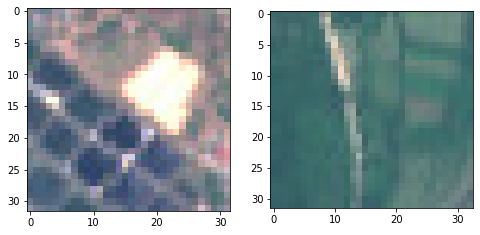

In [8]:
aqua_path = f'{data_dir}aquaculture/AQUACULTURE_32_bago_city-1107.jpg'
nonaqua_path = f'{data_dir}non-aquaculture/AGRICULTURE_32_bacuag-626.jpg'
aqua = plt.imread(aqua_path)
nonaqua = plt.imread(nonaqua_path)
print(aqua.shape)

fig, ax = plt.subplots(1, 2, figsize=(8,8)) 
ax[0].imshow(aqua)
ax[1].imshow(nonaqua);

## Create Pytorch Dataloader
In Pytorch, the `Dataset` class allows you to define a custom class to load the input and target for a dataset. In the next cell, we define a custom Pytorch dataset CFDDataset. The `__getitem__()` module returns an (image, mask) pair, converted to Pytorch tensors, for a specified index. 

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In the following, we create a function for generating pytorch dataloaders. we use `torch`'s `DataLoader` class to create a dataloader.  The dataloader manages fetching samples from the datasets (it can even fetch them in parallel using `num_workers`) and assembles batches of the datasets. 

In [10]:
def load_dataset(data_dir,batch_size,n_workers , phases, train_size=0.8):
        
    # Apply transforms to the (full) dataset
    dataset = datasets.ImageFolder(data_dir)
    transforms = get_transforms(size=224)
    classes = dataset.classes
    
    data = {
        phase: CustomDataset(dataset, transforms[phase])
        for phase in phases
    }
    
    # Randomly split the dataset into 80% train / 20% test 
    # by subsetting the transformed datasets into train and test sets
    
    indices = list(range(len(dataset)))
    split = int(train_size * len(dataset))
    np.random.shuffle(indices)
    
    split_indices = {'train': indices[:split], 'test': indices[split:]}
    data = {
        phase: Subset(data[phase], indices=split_indices[phase])
        for phase in phases
    }
    
    data_loader = {
        phase: torch.utils.data.DataLoader(
            data[phase], 
            batch_size=batch_size, 
            num_workers=n_workers,
            shuffle=True
        )
        for phase in phases
    }
    
    return data, data_loader, classes

def get_transforms(size):
    imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

    return {
        "train": transforms.Compose(
            [
                transforms.RandomResizedCrop(size),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(imagenet_mean, imagenet_std)
            ]
        ),
        "val": transforms.Compose(
            [
                transforms.Resize(size),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize(imagenet_mean, imagenet_std)
            ]
        ),
        "test": transforms.Compose(
            [
                transforms.Resize(size),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize(imagenet_mean, imagenet_std)
            ]
        ),
    }

## Load the images as a PyTorch Dataset


In [11]:
# Load dataset    
phases = ["train", "test"]
batch_size = 4
n_workers = 2
data, data_loader, classes = load_dataset(
    data_dir,batch_size,n_workers , phases=phases, train_size=0.8
)   
print("Train/test sizes: {}/{}".format(len(data['train']), len(data['test'])))

Train/test sizes: 2864/716


<a name="methodology"></a>
# Model Development

In this section, we'll briefly dicuss how to implement one type of model for image recognition architecture called ResNet. To learn more about the semantic segmentation, we recommend reading this [article](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)

## Instantiate Model
We can now instantiate a ResNet model. To make sure it works, we pass a sample batch through the network and check that there are no errors.

In [20]:
model = models.resnet18(pretrained=True)
print(model)
input, target = next(iter(data_loader['train']))
pred = model(input)
pred.shape

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

torch.Size([4, 1000])

## Training Function

We can now proceed to model training and evaluation.

This section has three major parts:

1. Specify the criterion, optimizer, and hyperparameters (e.g. n_epochs, learning rate, etc.).
2. Train the model on the training set by updating its weights to minimize the loss function.
3. Evaluate the model on the test set to observe performance on new, unseen data.
4. Repeat steps 2 and 3 `n_epochs` times.

Let's start by creating our train function.

In [13]:
def train(model, dataloader, criterion, optimizer):
  model.train(True)  

  for input, target in tqdm(dataloader, total=len(dataloader)):
    input = input.to(device)
    target = target.to(device)
    
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
      output = model(input)
      loss = criterion(output, target)

      loss.backward()
      optimizer.step()

  return loss

## Evaluation Function
Next, let's define the model evaluation function.

In [14]:
def evaluate(data_loader, class_names, model, criterion):
    model.eval()

    y_actuals, y_preds = [], []
    confusion_matrix = torch.zeros(len(class_names), len(class_names))

    for inputs, labels in tqdm(data_loader, total=len(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            probs, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        y_actuals.extend(labels.cpu().numpy().tolist())
        y_preds.extend(preds.data.cpu().numpy().tolist())
    
    epoch_results = eval(y_actuals, y_preds)
    confusion_matrix = get_confusion_matrix(
        y_actuals, y_preds, list(range(len(class_names)))
    )
    cm_metrics = get_cm_metrics(
        confusion_matrix, list(confusion_matrix.columns)
    )
    print(epoch_results)
    return loss
def eval(y_true, y_pred):

    return {
        "overall_accuracy": accuracy_score(y_true, y_pred),
        "kappa": cohen_kappa_score(y_true, y_pred),
        "recall_score": recall_score(y_true, y_pred, average="macro"),
        "precision_score": precision_score(y_true, y_pred, average="macro"),
        "f1_score": f1_score(y_true, y_pred, average="macro"),
    }

def get_confusion_matrix(y_val, y_pred, labels):
    
    y_pred = pd.Series(y_pred, name='Predicted')
    y_val = pd.Series(y_val, name='Actual')
    
    cm = confusion_matrix(y_val, y_pred, labels=labels)
    return pd.DataFrame(cm, index=labels, columns=labels)

def get_cm_metrics(confusion_matrix, class_names):

    metrics = {}
    for i in class_names:
        tp = confusion_matrix.loc[i, i]
        fn = confusion_matrix.loc[i, :].drop(i).sum()
        fp = confusion_matrix.loc[:, i].drop(i).sum()
        
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 / (recall ** -1 + prec ** -1) if prec + recall > 0 else 0
        
        scores = {
            "precision": prec*100, 
            "recall": recall*100, 
            "f1_score": f1*100
        }
        
        metrics[i] = scores
    metrics = pd.DataFrame(metrics).T
    
    return metrics

## Hyperparameters

In the next cell, we'll define our hyperparameters (number of epochs, learning rate), criterion, and optimizer.

In [21]:
classes = ['aquaculture','non_aquaculture']
n_epochs = 15
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train and Evaluate Model
Putting it all together, we can now commence training and evaluation in the following cell.

In [22]:
model.cuda()
for epoch in range(1, n_epochs + 1):    
  print("\nEpoch {}/{}".format(epoch, n_epochs))
  print("-" * 10)
  
  train_loss = train(
      model,
      data_loader["train"],
      criterion,
      optimizer
  )
  val_loss = evaluate(
      data_loader['test'],
      ['aquaculture','non-aquaculture'],
      model, 
      criterion
  )
  print('Train loss: {}, Val loss: {}'.format(
      train_loss.cpu().detach().numpy(), 
      val_loss.cpu().detach().numpy())
  )


Epoch 1/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.8491620111731844, 'kappa': 0.6969834713982304, 'recall_score': 0.8489347510495546, 'precision_score': 0.8481479451625784, 'f1_score': 0.8484810483744551}
Train loss: 0.1899411976337433, Val loss: 0.5302247405052185

Epoch 2/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.8715083798882681, 'kappa': 0.7382188133370424, 'recall_score': 0.8644171538431358, 'precision_score': 0.8850864463700817, 'f1_score': 0.8681663531201218}
Train loss: 0.5303491353988647, Val loss: 0.14811885356903076

Epoch 3/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.8840782122905028, 'kappa': 0.76387851432749, 'recall_score': 0.8771648291285754, 'precision_score': 0.8979862215156333, 'f1_score': 0.8811171324719386}
Train loss: 1.041139841079712, Val loss: 0.25325673818588257

Epoch 4/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.9036312849162011, 'kappa': 0.8040425835726412, 'recall_score': 0.897677247224075, 'precision_score': 0.9151212319790302, 'f1_score': 0.9015132637337007}
Train loss: 0.5319427251815796, Val loss: 0.22536681592464447

Epoch 5/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.8812849162011173, 'kappa': 0.7584997301672963, 'recall_score': 0.8749911719700239, 'precision_score': 0.8924558982950626, 'f1_score': 0.8785731244775112}
Train loss: 0.5059008598327637, Val loss: 0.30297183990478516

Epoch 6/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.8952513966480447, 'kappa': 0.7884527505081862, 'recall_score': 0.8926393847843999, 'precision_score': 0.896959888296522, 'f1_score': 0.8941511096393451}
Train loss: 0.820595383644104, Val loss: 0.9198906421661377

Epoch 7/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.8701117318435754, 'kappa': 0.7346330421475483, 'recall_score': 0.8616353435084553, 'precision_score': 0.8900088013269694, 'f1_score': 0.8658924892301929}
Train loss: 0.532889187335968, Val loss: 0.31757938861846924

Epoch 8/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.9008379888268156, 'kappa': 0.8002451943479559, 'recall_score': 0.8995291717346098, 'precision_score': 0.9008723859914336, 'f1_score': 0.9001129810290116}
Train loss: 0.07038308680057526, Val loss: 0.11183218657970428

Epoch 9/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.8784916201117319, 'kappa': 0.7582057572275875, 'recall_score': 0.8831992780633264, 'precision_score': 0.8827397560899144, 'f1_score': 0.8784894869178987}
Train loss: 0.22794109582901, Val loss: 0.1725434958934784

Epoch 10/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.9217877094972067, 'kappa': 0.8419438509630167, 'recall_score': 0.9190096912151293, 'precision_score': 0.9245803614735654, 'f1_score': 0.9208964646464646}
Train loss: 0.7093626856803894, Val loss: 0.2771259844303131

Epoch 11/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.9189944134078212, 'kappa': 0.8364382547322153, 'recall_score': 0.9166241613371522, 'precision_score': 0.9209047162257509, 'f1_score': 0.9181669136425261}
Train loss: 0.7691124081611633, Val loss: 0.04902106523513794

Epoch 12/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.8938547486033519, 'kappa': 0.7840240678854077, 'recall_score': 0.8875269745360379, 'precision_score': 0.9061125136715378, 'f1_score': 0.891383495145631}
Train loss: 0.11113056540489197, Val loss: 0.05138688534498215

Epoch 13/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.9106145251396648, 'kappa': 0.8204346497174698, 'recall_score': 0.9107388080197747, 'precision_score': 0.9098126414193215, 'f1_score': 0.9102109916293069}
Train loss: 0.3437750041484833, Val loss: 0.006655938923358917

Epoch 14/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.8840782122905028, 'kappa': 0.7678630021405916, 'recall_score': 0.8856397379055989, 'precision_score': 0.8835539460539461, 'f1_score': 0.8838314433886469}
Train loss: 0.3754560351371765, Val loss: 0.05483461916446686

Epoch 15/15
----------


  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

{'overall_accuracy': 0.9203910614525139, 'kappa': 0.8386060932013034, 'recall_score': 0.9160160081610232, 'precision_score': 0.9273059934874424, 'f1_score': 0.9190840148698884}
Train loss: 0.22604113817214966, Val loss: 0.02566220425069332


## Save Model

In [ ]:
model_dir = cwd+"models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)    

model_file = model_dir + 'best_model.pth'
torch.save(model.state_dict(), model_file)
print('Model successfully saved to {}'.format(model_file))

# Evaluate on an image

## Load Model

In [24]:
model_dir = f"{cwd}/models/"
model_file = model_dir + 'best_model.pth'

loaded_model = models.resnet18(pretrained=True)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Model file ./drive/My Drive/Colab Notebooks/aquafarm-mapping//models/best_model.pth successfully loaded.


## Define a predict function
We now define a function to input an image and use the model to classify a single image as aquaculture or non-aquaculture 

In [25]:
def predict(image, classes, model, transform):
    image = transform(image).cuda()
    model.eval()
    output = model(image.unsqueeze(0))
    prob = torch.nn.functional.softmax(output, dim=1)
    top_p, top_class = prob.topk(1, dim = 1)
    label = classes[top_class[0]]
    return label, float(top_p)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Test on an image
You can select any image from the dataset or upload your own to test the model. update the value for the `image_path` variable.

aquaculture 0.9355921149253845


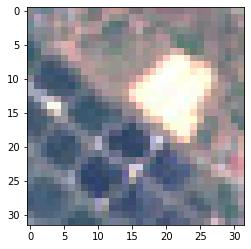

In [26]:
image_path = f'{data_dir}/aquaculture/AQUACULTURE_32_bago_city-1107.jpg'
image = plt.imread(image_path)
label, prob = predict(image, classes, model, transform)
plt.imshow(image)
print(label, prob)